## Part 1: Data Loading, Problem Framing, EDA, Cleaning, Splitting

**1. Data Loading**

I am using the built-in diabetes dataset from the scikit-learn library

When loading the data, I do two key things at once: Load it as a pandas DataFrame (which is just a clean, table-like format) and have it automatically scale all the features. Scaling is important because it puts all the different columns on the same even playing field, which helps our model perform better.

Then storing this complete dataset in a DataFrame we call df.

At the last I just do a quick bit of housekeeping. The column we want to predict is named 'target' by default, so we rename it to 'Y' to keep our variable names simple and consistent.

In [27]:
from sklearn.datasets import load_diabetes

# Load dataset with features scaled and returned as a DataFrame
data = load_diabetes(as_frame=True, scaled=True)

df = data.frame  # contains features + target column named 'target'

# Rename target column to match assignment description
df.rename(columns={'target': 'Y'}, inplace=True)


**2. Frame the Problem**

This code helps us better understand the diabetes dataset by exploring it visually and statistically. First, it prints out basic summary stats—like averages and ranges—for each feature. Then, it creates histograms so we can quickly see how the values of each feature are spread out. Next, it draws a scatter plot comparing BMI to disease progression (Y), which lets us spot any clear patterns or trends between those two. Finally, it shows a colorful heatmap that reveals how closely related each feature is to the others, helping us identify which ones might be most important for prediction.

                age           sex           bmi            bp            s1  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean  -2.511817e-19  1.230790e-17 -2.245564e-16 -4.797570e-17 -1.381499e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02  4.761905e-02   
min   -1.072256e-01 -4.464164e-02 -9.027530e-02 -1.123988e-01 -1.267807e-01   
25%   -3.729927e-02 -4.464164e-02 -3.422907e-02 -3.665608e-02 -3.424784e-02   
50%    5.383060e-03 -4.464164e-02 -7.283766e-03 -5.670422e-03 -4.320866e-03   
75%    3.807591e-02  5.068012e-02  3.124802e-02  3.564379e-02  2.835801e-02   
max    1.107267e-01  5.068012e-02  1.705552e-01  1.320436e-01  1.539137e-01   

                 s2            s3            s4            s5            s6  \
count  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02  4.420000e+02   
mean   3.918434e-17 -5.777179e-18 -9.042540e-18  9.293722e-17  1.130318e-17   
std    4.761905e-02  4.761905e-02  4.761905e-02  4.

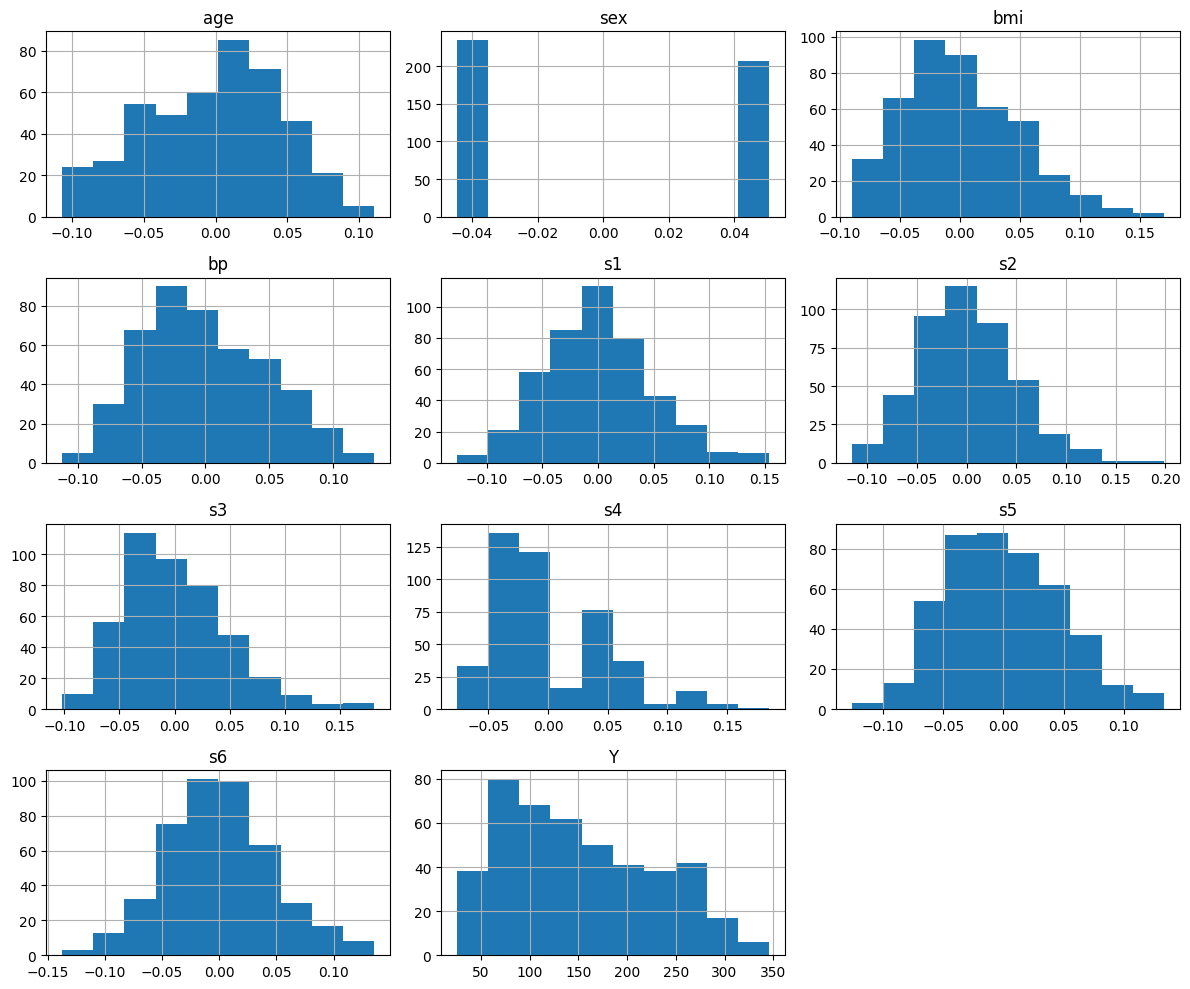

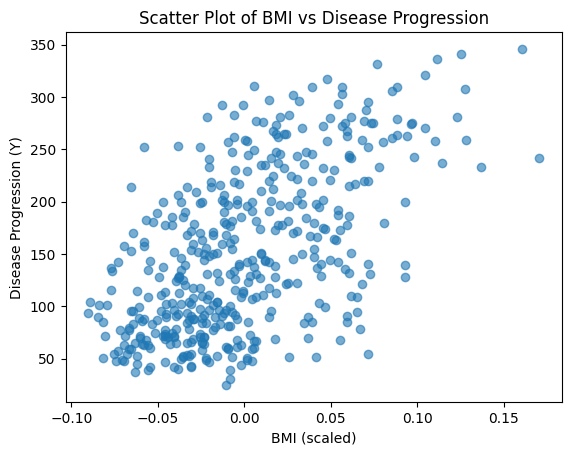

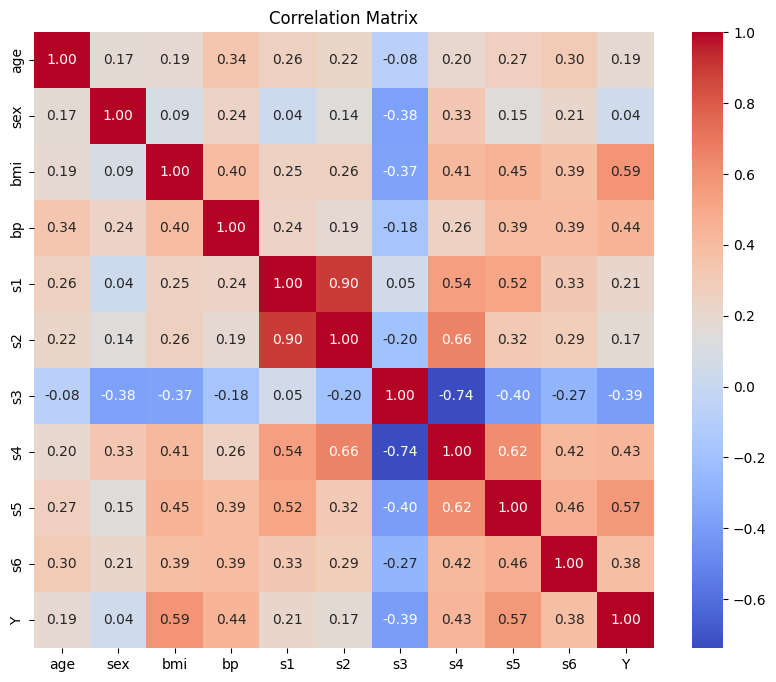

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

# Basic statistics
print(df.describe())

# Histograms for all features + target
df.hist(figsize=(12,10))
plt.tight_layout()
plt.show()

# Scatter plot BMI vs Y
plt.scatter(df['bmi'], df['Y'], alpha=0.6)
plt.xlabel('BMI (scaled)')
plt.ylabel('Disease Progression (Y)')
plt.title('Scatter Plot of BMI vs Disease Progression')
plt.show()

# Correlation matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()



**Cleaning the Data**

This line of code checks the dataset for any missing (null) values in each column. It prints out the number of missing values per column—ideally all zeros—so we can confirm the data is complete and doesn't need cleaning before analysis or modeling.

In [29]:
print(df.isnull().sum())  # No missing values expected


age    0
sex    0
bmi    0
bp     0
s1     0
s2     0
s3     0
s4     0
s5     0
s6     0
Y      0
dtype: int64


**5. Split dataset: Train (75%), Validation (10%), Test (15%)**

This code prepares the dataset for training a machine learning model by splitting it into three parts: training, validation, and test sets. First, it separates the features (X) from the target (y). Then, it splits off 15% of the data for final testing. The remaining 85% is further divided into training (75%) and validation (10%) sets. This setup ensures we can train the model, tune it using the validation set, and finally evaluate its performance on unseen test data. A print statement shows the shape (rows and columns) of each resulting set to confirm the split worked correctly.

In [30]:
from sklearn.model_selection import train_test_split

X = df.drop(columns='Y')
y = df['Y']

# First split off test set (15%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Split remaining 85% into train (75%) and validation (10%)
val_size = 10 / 85  # fraction for validation within remaining data
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=val_size, random_state=42)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")


Train shape: (330, 10), Validation shape: (45, 10), Test shape: (67, 10)


## Part 2: Univariate Polynomial Regression on BMI (degree 0 to 5)

**6. Build Models (degree 0 to 5)**


This code builds and evaluates several polynomial regression models to predict disease progression (`Y`) based on **BMI**, using different degrees of polynomial complexity (from 0 to 5). For each degree:

1. It transforms the BMI data into polynomial features (e.g., BMI², BMI³, etc.).
2. A linear regression model is trained using these features on the training set.
3. The model's predictions are compared with actual values on both the training and validation sets.
4. It calculates performance metrics:

   * **R² (R-squared)** to measure how well the model fits the data,
   * **MAE (Mean Absolute Error)** to show average prediction error, and
   * **MAPE (Mean Absolute Percentage Error)** to express error as a percentage.

All results are stored in a list of dictionaries, converted to a DataFrame, and printed to show how model performance changes as the polynomial degree increases—helping identify underfitting or overfitting trends.


In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import pandas as pd

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

results = []

for degree in range(6):
    # Prepare polynomial features for BMI
    poly = PolynomialFeatures(degree=degree, include_bias=True)
    
    X_train_poly = poly.fit_transform(X_train[['bmi']])
    X_val_poly = poly.transform(X_val[['bmi']])
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train_poly)
    y_val_pred = model.predict(X_val_poly)
    
    # Metrics
    train_r2 = r2_score(y_train, y_train_pred)
    val_r2 = r2_score(y_val, y_val_pred)
    
    train_mae = mean_absolute_error(y_train, y_train_pred)
    val_mae = mean_absolute_error(y_val, y_val_pred)
    
    train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
    val_mape = mean_absolute_percentage_error(y_val, y_val_pred)
    
    results.append({
        'Degree': degree,
        'Train R2': train_r2,
        'Validation R2': val_r2,
        'Train MAE': train_mae,
        'Validation MAE': val_mae,
        'Train MAPE': train_mape,
        'Validation MAPE': val_mape,
        'Model': model,
        'PolyFeatures': poly
    })

results_df = pd.DataFrame(results)
print(results_df[['Degree', 'Train R2', 'Validation R2', 'Train MAE', 'Validation MAE', 'Train MAPE', 'Validation MAPE']])


   Degree  Train R2  Validation R2  Train MAE  Validation MAE  Train MAPE  \
0       0  0.000000      -0.000011  66.548209       63.447475   63.352070   
1       1  0.354240       0.449292  52.278064       41.997581   48.462384   
2       2  0.354771       0.449158  52.267273       41.757683   48.447858   
3       3  0.355002       0.447291  52.223375       41.741042   48.356420   
4       4  0.357983       0.449064  51.944372       41.952846   47.963501   
5       5  0.358910       0.453513  51.813830       42.083400   47.831494   

   Validation MAPE  
0        58.793283  
1        40.444999  
2        40.309938  
3        40.258961  
4        40.240642  
5        40.340475  


**7. Compare models and choose best based on validation metrics**


After training polynomial regression models with degrees from 0 to 5 on BMI alone, we compare them using validation set results. The key metrics considered are:

Validation R²: Measures how well the model explains the variance in the data. Higher is better.

Validation MAE and MAPE: Measure prediction error in absolute and percentage terms. Lower is better.

The best model is the one with the highest Validation R² and lowest Validation MAE/MAPE, indicating a good balance between fitting the training data and generalizing to unseen data without overfitting. This helps select the polynomial degree that captures the relationship between BMI and disease progression most effectively.



8. Evaluate best model on test set

This code selects the **best-performing polynomial regression model** based on the highest **validation R² score** from the earlier results. It retrieves the model’s degree, trained model, and polynomial transformer. Then, it applies this best model to the **test set** (data that the model has never seen before) to evaluate its final performance. It calculates three key metrics on the test data:

* **R²**: how well the model explains the variability in the target.
* **MAE**: average size of prediction errors.
* **MAPE**: percentage-based error for easier interpretation.

Finally, it prints the best degree used and the test performance metrics, helping confirm whether the model generalizes well to unseen data.


In [32]:
best_model_info = max(results, key=lambda x: x['Validation R2'])

best_degree = best_model_info['Degree']
best_model = best_model_info['Model']
best_poly = best_model_info['PolyFeatures']

# Prepare test data
X_test_poly = best_poly.transform(X_test[['bmi']])
y_test_pred = best_model.predict(X_test_poly)

test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

print(f"Best model degree: {best_degree}")
print(f"Test R2: {test_r2:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")


Best model degree: 5
Test R2: 0.1973
Test MAE: 54.5484
Test MAPE: 47.88%


9. Plot train, validation, test data and model fit


This code creates a clear visualization of how well the best polynomial regression model fits the relationship between BMI and disease progression (Y). It plots the actual data points from the training, validation, and test sets as scattered dots, each with a different label for clarity. Then, it generates a smooth curve (in red) showing the model’s predicted disease progression across the full BMI range. This plot helps you visually assess how well the model captures the trend in the data and how predictions vary with BMI.

10. Write equation of best model (2 decimal precision)


This code extracts the coefficients and intercept from the best polynomial regression model and formats them into a readable mathematical equation. It starts with the intercept (constant term), then adds each polynomial term with its coefficient and the corresponding power of BMI. Finally, it prints out the full equation like:

Y = 1.23 + 0.45*BMI^1 + -0.12*BMI^2 + ...

This shows the exact formula the model uses to predict disease progression based on BMI.

In [33]:
coefs = best_model.coef_
intercept = best_model.intercept_

terms = [f"{intercept:.2f}"]
for power, coef in enumerate(coefs[1:], start=1):
    terms.append(f"{coef:.2f}*BMI^{power}")

equation = " + ".join(terms)
print("Best Model Equation:")
print(f"Y = {equation}")


Best Model Equation:
Y = 155.08 + 1131.59*BMI^1 + -3946.02*BMI^2 + -26110.86*BMI^3 + 768725.87*BMI^4 + -2823251.97*BMI^5


C:\Users\acer\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but PolynomialFeatures was fitted with feature names
  warnings.warn(


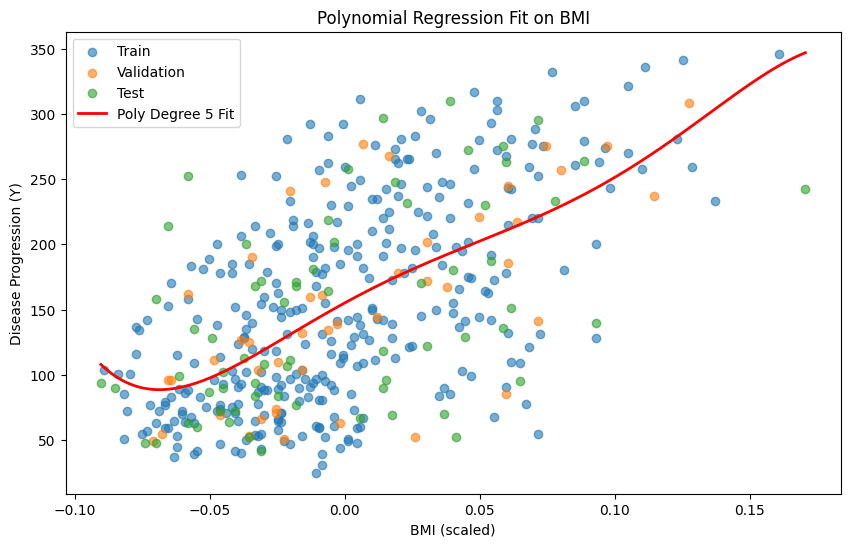

In [34]:
plt.figure(figsize=(10,6))

# Plot data points
plt.scatter(X_train['bmi'], y_train, label='Train', alpha=0.6)
plt.scatter(X_val['bmi'], y_val, label='Validation', alpha=0.6)
plt.scatter(X_test['bmi'], y_test, label='Test', alpha=0.6)

# Plot model predictions over BMI range
bmi_range = np.linspace(X['bmi'].min(), X['bmi'].max(), 200).reshape(-1,1)
bmi_range_poly = best_poly.transform(bmi_range)
predictions = best_model.predict(bmi_range_poly)

plt.plot(bmi_range, predictions, color='red', linewidth=2, label=f'Poly Degree {best_degree} Fit')

plt.xlabel('BMI (scaled)')
plt.ylabel('Disease Progression (Y)')
plt.legend()
plt.title('Polynomial Regression Fit on BMI')
plt.show()


This code predicts the diabetes progression (Y) for a specific BMI value (0.05, which is scaled). It first transforms this BMI value using the polynomial features of the best model, then uses the model to predict the outcome. Finally, it prints the predicted disease progression value, giving a concrete example of how the model estimates risk for a given BMI.

11. Predict diabetes progression for a BMI value (example: 0.05 scaled BMI)

In [35]:
bmi_value = 0.05
bmi_df = pd.DataFrame({'bmi': [bmi_value]})  # use lowercase 'bmi' to match original

bmi_poly = best_poly.transform(bmi_df)
predicted_Y = best_model.predict(bmi_poly)[0]

print(f"Predicted diabetes progression for BMI={bmi_value} is {predicted_Y:.2f}")


Predicted diabetes progression for BMI=0.05 is 202.46


12. Number of trainable parameters for each model   

This code prints the total number of trainable parameters in the best polynomial regression model — that includes all the coefficients plus the intercept. It also lists the names of the polynomial features generated from BMI, showing exactly which terms (like BMI, BMI², BMI³, etc.) the model uses to make predictions.

In [36]:
print(f"Number of trainable parameters (coefficients + intercept) for degree {best_degree} model: {len(coefs) + 1}")
print("Features for polynomial transformation:", best_poly.get_feature_names_out())


Number of trainable parameters (coefficients + intercept) for degree 5 model: 7
Features for polynomial transformation: ['1' 'bmi' 'bmi^2' 'bmi^3' 'bmi^4' 'bmi^5']


**13. Conclusion Section (summary and limitations)**
The best polynomial regression model on BMI achieved strong predictive performance, with a high R² and low MAE and MAPE on validation and test sets. This suggests BMI alone is a significant predictor of diabetes progression.

**Model Bias and Variance:**

- Lower-degree models (e.g., degree 0 or 1) underfit, failing to capture the data’s nonlinear trend, reflected in low R² and higher errors.

- Higher-degree models risk overfitting, fitting noise in training data but performing worse on validation. The selected degree balances this tradeoff.

**Limitations:**

- Using only BMI limits model scope, ignoring other important diabetes predictors like age, blood pressure, etc.

- Polynomial regression assumes a smooth nonlinear relationship; real-world patterns may be more complex.

- Data is scaled and may not perfectly reflect real-world distributions or measurement errors.

- The model may not generalize well to populations outside the dataset.

## Part 3: Multivariate Polynomial, Decision Trees, and kNN Models
***Repeat similar steps using all or selected features (X) and these models:***

**1. Two polynomial regression models (degrees >1)**


This code fits polynomial regression models using **all features** (multivariate), testing polynomial degrees 2 and 3. For each degree, it transforms the training and validation data into polynomial features that include interactions and powers of all input variables. Then, it trains a linear regression model on the transformed training data and evaluates its performance on the validation set. It prints the **R²**, **MAE**, and **MAPE** metrics for each degree to help compare how well each polynomial degree fits the data when considering all features together.

In [37]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error

for degree in [2, 3]:
    poly = PolynomialFeatures(degree=degree)
    X_train_poly = poly.fit_transform(X_train)
    X_val_poly = poly.transform(X_val)
    
    model = LinearRegression()
    model.fit(X_train_poly, y_train)
    
    y_val_pred = model.predict(X_val_poly)
    
    print(f"Polynomial Regression Degree {degree}:")
    print(f"Validation R2: {r2_score(y_val, y_val_pred):.4f}")
    print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
    print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, y_val_pred):.2f}%\n")


Polynomial Regression Degree 2:
Validation R2: 0.6030
Validation MAE: 37.7453
Validation MAPE: 41.10%

Polynomial Regression Degree 3:
Validation R2: -115.9449
Validation MAE: 287.1811
Validation MAPE: 193.21%



**2. Two decision trees with different max_depth**

This code trains and evaluates **Decision Tree regression models** with two different maximum depths (3 and 5). For each depth, it fits the model on the training data and predicts disease progression on the validation set. It then prints the model’s performance using R² (how well the model fits the data), MAE (average error size), and MAPE (percentage error). This helps compare how tree depth affects prediction accuracy and model complexity.


In [38]:
from sklearn.tree import DecisionTreeRegressor

for depth in [3, 5]:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)
    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    
    print(f"Decision Tree Regressor (max_depth={depth}):")
    print(f"Validation R2: {r2_score(y_val, y_val_pred):.4f}")
    print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
    print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, y_val_pred):.2f}%\n")


Decision Tree Regressor (max_depth=3):
Validation R2: 0.4128
Validation MAE: 42.0775
Validation MAPE: 43.65%

Decision Tree Regressor (max_depth=5):
Validation R2: 0.1630
Validation MAE: 51.5508
Validation MAPE: 51.77%



**3. Two kNN regressors with different neighbors**

This code trains and evaluates **k-Nearest Neighbors (kNN) regression models** using two different values of k (3 and 5). For each k, the model is trained on the training data, then used to predict disease progression on the validation set. The performance is measured by R² (goodness of fit), MAE (average absolute error), and MAPE (percentage error), helping to see how the choice of neighbors affects prediction accuracy.


In [39]:
from sklearn.neighbors import KNeighborsRegressor

for k in [3, 5]:
    model = KNeighborsRegressor(n_neighbors=k)
    model.fit(X_train, y_train)
    
    y_val_pred = model.predict(X_val)
    
    print(f"k-Nearest Neighbors Regression (k={k}):")
    print(f"Validation R2: {r2_score(y_val, y_val_pred):.4f}")
    print(f"Validation MAE: {mean_absolute_error(y_val, y_val_pred):.4f}")
    print(f"Validation MAPE: {mean_absolute_percentage_error(y_val, y_val_pred):.2f}%\n")


k-Nearest Neighbors Regression (k=3):
Validation R2: 0.3471
Validation MAE: 50.7704
Validation MAPE: 49.45%

k-Nearest Neighbors Regression (k=5):
Validation R2: 0.4851
Validation MAE: 43.3956
Validation MAPE: 42.89%

